# FIGHTER

## About
In this study, we propose **FIGHTER**, **F**ire **I**ntervention via a **G**irvan-Newman **H**euristic **T**hrough a neighborhood-based **E**dge-**R**emoval approach, a fire intervention method that adapts a Girvan-Newman scheme for edge removal except it does not detect communities and that it also takes into consideration the location of where edges are being pruned.

### Importation of Packages

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
import time
from IPython.display import clear_output
import re
import copy

### Importation of Dataset
The dataset that we use to construct the network is the **ForestCoverType Dataset**. This dataset contains tree observations (30 meter $\times$ 30 meter grids of forests) of the Roosevelt National Forest in Colorado. Each grid includes several topographic data such as elevations, slopes and aspects. 

In [4]:
df = pd.read_csv('./covtype.csv')
df.info() # Know more about the dataset
df.head() # Query in the first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area1                      581012 non-null int64
Wilderness_Area2                      581012 non-null int64
Wilderness_Area3                      581012 non-null int64
Wilderness_Area4                      581012 non-null int64
Soil_Type1                            581012 non-

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


### Main INCINERATE( ) method
The main method called in a fire simulation. 

*Input*: (None) <br> *Output*: (None) - the resulting graph $g$ after fire has propagated in the network

In [5]:
# main method used to igniting the forest (INCINERATE)
def incinerate():
	burning_nodes = get_burning([n for n in g.nodes])
	for ignition_node in burning_nodes:
		neighbors = [n for n in g.neighbors(ignition_node)]
		if (len(neighbors) == 0):
			break
		for nb in neighbors:
			active_nb = get_burning([n for n in g.neighbors(nb)])

			s = 0
			for burning_nb in active_nb:
				w = g.get_edge_data(burning_nb, nb)['w']
				s = min(1,s+w)

			ths = g.nodes[nb]['threshold_switch']
			if (s >= ths and g[ignition_node][nb]['color'] != 'brown'):
				g.nodes[nb]['fire_state'] = 'burning'
				colors[nb-1] = 'orange'
				g.nodes[nb]['color'] = 'orange'
				g[ignition_node][nb]['color'] = 'orange'
	lifeline_update()
	life_edge_update()
	update_active_neighbors()
	for nd in [n for n in g.nodes]:
		if g.nodes[nd]['fire_state'] == 'burnt':
			g.nodes[nd]['color'] == 'brown'
			for item in [nb for nb in g.neighbors(nd)]:
				g[nd][item]['color'] = 'brown'

### Main method to simulate wind
We use this method to simulate wind at every $t$ timesteps.

*Input*: (None) <br> *Output*: the resulting graph $g$ after a random region in the network graph has been selected for the simulation of wind; also returns <code>center_node</code> - the $xy$-coordinate position of the central node affected by the wind, $a$ and $b$ are the major and minor axis distances of the elliptical region afected by the wind

In [6]:
def simulate_wind():
	nn = g.number_of_nodes()
	snn = int(np.sqrt(nn))
	center_node = rnd.randint(1,nn)
	center_node_pos = g.nodes[center_node]['pos']
	while g.nodes[center_node]['fire_state'] == 'empty':
		center_node = rnd.randint(1,nn)
	#random_bound = snn
	random_bound = 4
	a = 0
	b = 0
	sign = [-1,1]
	while a == b:
		a = rnd.randint(1,random_bound)
		b = rnd.randint(1,random_bound)
	c_max = max(a,b)-1
	c = rnd.randint(1,c_max)*sign[rnd.randint(0,1)]

	vertical_north = min(center_node+b,int(np.ceil(center_node/snn)*snn))
	vertical_south = max(center_node-b, int(np.floor((center_node-1)/snn)*snn+1))
	horizontal_west = max(center_node-snn*a, center_node%snn)
	horizontal_east = min(center_node+snn*a, center_node%snn + (nn-snn)) 
	
	elliptical_nodes = []
	for j in range(horizontal_west, horizontal_east+1, snn):
		axis = j
		for i in range(axis-b,axis+b+1):
			elliptical_nodes.append(i)

	weak_nodes = []
	focus_nodes = []
	if(max(a,b) == b):
		focus = min(center_node+c, np.ceil(center_node/snn)*snn) if c > 0 else max(center_node-c, np.floor((center_node-1)/snn)*snn+1)
		lower_left_weak_corner = horizontal_west+np.sign(c)*b
		lower_right_weak_corner = horizontal_east+np.sign(c)*b
		upper_left_weak_corner = horizontal_west+c
		upper_right_weak_corner = horizontal_east+c
		for p in range(lower_left_weak_corner, lower_right_weak_corner+1, snn):
			ax = p
			min_val = ax if (min(ax, ax+(b-abs(c)) == ax)) else ax+(b-abs(c))+1
			max_val = ax+(b-abs(c)) if max(ax, ax+(b-abs(c))) == ax+(b-abs(c)) else ax+1
			for q in range(min_val, max_val):
				weak_nodes.append(q)
		for i in range(horizontal_west+c, horizontal_east+c+1, snn):
			focus_nodes.append(i)
	else:
		focus = min(center_node+snn*c, center_node%snn + (nn-snn)) if c > 0 else max(center_node-snn*c, center_node%snn)
		lower_left_weak_corner = vertical_south+np.sign(c)*a
		lower_right_weak_corner = vertical_south+c
		upper_left_weak_corner = vertical_north+np.sign(c)*a
		upper_right_weak_corner = vertical_north+c
		for p in range(lower_left_weak_corner, upper_left_weak_corner+1):
			ax = p
			min_val = ax if min(ax, ax+(a-abs(c))) == ax else ax+(a-abs(c))+1
			max_val = ax+(a-abs(c)) if max(ax, ax+(a-abs(c))) == ax+(a-abs(c)) else ax+1
			for q in range(min_val, max_val, snn):
				weak_nodes.append(q)
		for i in range(vertical_south+c, vertical_north+c+1):
			focus_nodes.append(i)

	strong_nodes = [n for n in elliptical_nodes if n not in weak_nodes]

	for n1 in weak_nodes:
		for n2 in weak_nodes:
			if (n1 == n2):
				continue
			try:
				if (n1,n2) in edge_list:
					n_min = min(n1, n2)
					n_max = max(n1, n2)
					wd = g[n1][n2]['wind_dir']
					pos1 = g.nodes[n_min]['pos']
					pos2 = g.nodes[n_max]['pos']
					posf = g.nodes[focus]['pos']
					if wd not in [-45,45]:
						if a > b:
							wd = 89.9 if pos1[1] >= posf[1] and pos2[1] >= posf[1] else -89.9
							wd = 0 if pos1[1] == pos2[1] else wd
						else:
							wd = -89.9 if pos1[0] <= posf[0] and pos2[0] <= posf[0] else 89.9
							wd = 0 if pos1[0] == pos2[0] else wd
					w_e = edge_weight(max_speed, epsilon, -1, wd, dist(pos1,pos2))
					g[n1][n2]['edge_strength'] = -1
					g[n1][n2]['wind_dir'] = wd
			except:
				ret()
	
	for n1 in strong_nodes:
		for n2 in strong_nodes:
			if (n1 == n2):
				continue
			try:
				if (n1,n2) in edge_list:
					wd = g[n1][n2]['wind_dir']
					pos1 = g.nodes[n1]['pos']
					pos2 = g.nodes[n2]['pos']
					posf = g.nodes[focus]['pos']
					if wd not in [-45,45]:
						if a > b:
							wd = 89.9 if pos1[1] >= posf[1] and pos2[1] >= posf[1] else -89.9
							wd = 0 if pos1[1] == pos2[1] else wd
						else:
							wd = -89.9 if pos1[0] <= posf[0] and pos2[0] <= posf[0] else 89.9
							wd = 0 if pos1[0] == pos2[0] else wd
					w_e = edge_weight(max_speed, epsilon, 1, wd, dist(pos1,pos2))
					g[n1][n2]['edge_strength'] = 1
					g[n1][n2]['wind_dir'] = wd
			except:
				ret()
	return (center_node_pos, a, b)

### Method to Draw Graphs
We use this method for drawing graphs, given some specific parameters.

*Input*: $g$ - the graph to be drawn, <br>
&nbsp; &nbsp; &nbsp; &nbsp; <code>ns</code> - an integer of the size of the nodes in the network <br>
&nbsp; &nbsp; &nbsp; &nbsp; <code>node_colors</code> - an iterable consisting of the colors of the nodes in the network <br>
&nbsp; &nbsp; &nbsp; &nbsp; <code>edge_colors</code> - an iterable consisting of the colors of the edges in the network <br>
&nbsp; &nbsp; &nbsp; &nbsp; <code>pos_dict</code> - a dictionary with the nodes as the keys and their $xy$-coordinate position as values <br>
&nbsp; &nbsp; &nbsp; &nbsp; <code>fs</code> - font-size of the labels of nodes (only if <code>with_labels=True</code>) <br>
*Output*: (None) - draws the graph $g$ using matplotlib

In [7]:
def draw_graph(g, ns, node_colors, edge_colors, pos_dict, fs):
	nx.draw(g, node_size=ns, node_color=node_colors, edge_color=edge_colors, with_labels=False, pos=pos_dict, font_size=fs)
	pos=nx.get_node_attributes(g,'pos')

In [ ]:
### remove in INCINERATE

### Intervention Strategy Methods
In this study, we propose an edge-removal-based strategy to reduce fire propgation in the forest network. There are two methods that we propose, one is using Girvan-Newman algorithm that detects and isolates a community of forests in the network graph. And the other is a new algorithm that we wrote called **FIGHTER**, **F**ire **I**ntervention via a **G**irvan-Newman **H**euristic **T**hrough a neighborhood-based **E**dge-**R**emoval approach, that adapts a Girvan-Newman scheme for edge removal except it does not detect communities and that it also takes into consideration the location of where edges are being pruned.

*Input*: $g$ - the graph <br>
&nbsp; &nbsp; &nbsp; &nbsp; $K$ - an integer denoting how many edges are we to prune from $g$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; <code>dist_threshold</code> - a float denoting the radius of the neighborhood-ball of the edges pruned in the graph (only for the **FIGHTER** algorithm) <br>
*Output*: A list of edges removed from the graph $g$

In [8]:
# remove K edges based on Girvan-Newman approach
def remove_links_gv(g, K):
	removed_edges = []
	for i in range(K):
		n1, n2 = get_max_edge_betweenness(g)
		g.remove_edge(n1,n2)
		removed_edges.append((n1,n2))
		calculate_edge_betweenness(g, [])
	return removed_edges

# removes K edges based on the FIGHTER approach: edge_betweenness_scores + location 
def remove_links_fighter(g, K, dist_threshold):
	n1, n2 = get_max_edge_betweenness(g)
	g.remove_edge(n1, n2)
	removed_edges = [(n1,n2)]
	n1_pos = g.nodes[n1]['pos']
	n2_pos = g.nodes[n2]['pos']
	ll = []
	calculate_edge_betweenness(g, ll)
	stop_condition = True # change this
	k = 1
	while (k < K and stop_condition):
		n1_prime, n2_prime = get_max_edge_betweenness(g)
		d = edge_distance((n1,n2), (n1_prime, n2_prime))
		if d < dist_threshold*dist_scale:
			removed_edges.append((n1_prime, n2_prime))
			g.remove_edge(n1_prime, n2_prime)
			n1 = n1_prime
			n2 = n2_prime
			n1_pos = g.nodes[n1_prime]['pos']
			n2_pos = g.nodes[n2_prime]['pos']
			ll = []
			k += 1
		else:
			ll.append((n1_prime, n2_prime))
		calculate_edge_betweenness(g, ll)
	
	return removed_edges

# calculates the edge_betweenness of all edges in the graph g
# lst is by default and empty list, it otherwise contains edges that should have a negative value for the edge betweenness score
def calculate_edge_betweenness(g, lst):
	eb_dict = nx.edge_betweenness_centrality(g)
	for k,v in eb_dict.items():
		g[k[0]][k[1]]['eb'] = v*(2*int(k not in lst)-1)

# method to get the edge with the highest betweenness score
def get_max_edge_betweenness(g):
	eb_dict = {}
	edge_list = [e for e in g.edges()]
	for e in edge_list:
		eb_dict[e] = g[e[0]][e[1]]['eb']
	return max(eb_dict, key=eb_dict.get)

# given two edges, calculate the shortest distance between them
def edge_distance(e1, e2):
	e11, e12 = e1
	e21, e22 = e2
	e11_pos = g.nodes[e11]['pos']
	e12_pos = g.nodes[e12]['pos']
	e21_pos = g.nodes[e21]['pos']
	e22_pos = g.nodes[e22]['pos']
	return min(dist(e11_pos, e21_pos),
			  dist(e11_pos, e22_pos),
			  dist(e12_pos, e21_pos),
			  dist(e12_pos, e22_pos))*dist_scale

### Helper Methods
Below are the helper methods used.

In [9]:
# count how many are burning currently in the map
def count_burning(g):
	burning = 0
	for i in range(1,g.number_of_nodes()+1):
		if (g.nodes[i]['fire_state'] == 'burning'):
			burning += 1
	return burning

# count how many are burnt currently in the map
def count_burnt(g):
	burnt = 0
	for i in range(1,g.number_of_nodes()+1):
		if (g.nodes[i]['fire_state'] == 'burnt'):
			burnt += 1
	return burnt

# count how many nodes in the network are not empty 
def count_non_empty(g):
	count = 0
	for n in g.nodes:
		if g.nodes[n]['fire_state'] != 'empty':
			count += 1
	return count

# compute euclidean distance (np might have it already?)
def dist(pair1, pair2):
	x1 = pair1[0]
	y1 = pair1[1]
	x2 = pair2[0]
	y2 = pair2[1]
	return pow(pow((x2-x1),2) + pow((y2-y1),2),1/2)*dist_scale

# determine the weight of edge, model needs to be fixed
def edge_weight(max_speed, eps, edge_strength, wind_direction, distance):
	c_e =rnd.uniform(0,1)
	psi = max_speed #user-defined
	epss = 1 if edge_strength in [0,1] else eps
	gamma = rnd.uniform(0.01,1)*psi*epss
	tau = wind_direction*180/np.pi # wind direction in radians
	delta = distance
	beta = max(2/np.pi*np.arctan(dist_scale * gamma *np.cos(tau) / delta),0.01)
	return round(beta,2)

# gets the angle between two nodes
def get_angle(pair1, pair2):
	x1 = pair1[0]
	y1 = pair1[1]
	x2 = pair2[0]
	y2 = pair2[1]
	m = 572.96 if x1 == x2 else (y2-y1)/(x2-x1)
	return np.arctan(m)*180/np.pi

# given a list of nodes, return those nodes that are burning
def get_burning(lst):
	burn_list = []
	for item in lst:
		if g.nodes[item]['fire_state'] == 'burning':
			burn_list.append(item)
	return burn_list

# get direction given aspect
def get_direction(a):
	if a < 22.5:
		return 'N'
	elif a < 67.5:
		return 'NE'
	elif a < 112.5:
		return 'E'
	elif a < 157.5:
		return 'SE'
	elif a < 202.5:
		return 'S'
	elif a < 247.5:
		return 'SW'
	elif a < 292.5:
		return 'W'
	elif a < 337.5:
		return 'NW'
	else:
		return 'N'

# return the max number from a list of lists
def get_max_of_max(l):
	m = 0
	for lst in l:
		m = max(m,max(lst))
	return m

# methods for updating fire life of the edges
def life_edge_update():
	for p in range(1,g.number_of_nodes()+1):
		for q in range(p+1,g.number_of_nodes()+1):
			try:
				if p == q:
					continue
				if ((p,q) in edge_list):
					if (g[p][q]['color'] == 'orange'):
						g[p][q]['life'] -= 1
					if (g[p][q]['life'] < 0):
						g[p][q]['color'] == 'brown'
			except:
				ret()
def ret():
	return

# updates the life of the fire in the node
def lifeline_update():
	for node in [n for n in g.nodes()]:
		if (g.nodes[node]['fire_state'] == 'burning'):
			g.nodes[node]['life'] -= 1
		if (g.nodes[node]['life'] < 0):
			g.nodes[node]['fire_state'] = 'burnt'
			g.nodes[node]['color'] = 'brown'
			colors[node-1] = 'brown'

# compute node threshold
def node_threshold(slope, elevation, ele_min, ele_max, aspect, aspect_dict):
	# calculate slope coefficient factor
	phi = np.tan(slope*np.pi/180)
	phi_s = 5.275*pow(phi,2)
	
	# calculate elevation factor
	h = (elevation-ele_min)/(ele_max-ele_min) * 2300
	h_prime = h*np.exp(-6)
	mmax = max(h_prime,1)
	logmax = np.log(mmax)
	xi = 1/(1+logmax)
	
	# get the aspect coefficient factor
	dirn = get_direction(aspect)
	alpha = aspect_dict[dirn]
	
	# stochastic component
	C_n = rnd.uniform(0,1)
	
	# compute node_threshold
	theta = -np.arctan(phi_s * xi * alpha)/np.pi + 0.5
	return round(theta,2)

# count how many neighbors are actively burning for each single node in the graph
def update_active_neighbors():
	for itemm in [n for n in g.nodes()]:
		num = 0
		for item in [n for n in g.neighbors(itemm)]:
			if g.nodes[item]['fire_state'] == 'burning':
				num += 1
		g.nodes[itemm]['num_of_active_neighbors'] = num

In [ ]:
### note remove this for INCINERATE and FIGHTER

### Method for Plotting
We intend to use this method to be able to plot some results of our experiments and give a visual interpretation.

In [10]:
# for plotting
def plt_list(l, markers, colors, steps, axes_range, title, xlabel, ylabel, labels, legend_pos):
	for i in range(1,len(l)):
		plt.plot(l[0], l[i], marker=markers[i-1], color=colors[i-1], label=labels[i-1])
	plt.axis(axes_range)
	plt.xticks(np.arange(axes_range[0],axes_range[1],step=steps[0]))
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.legend(loc=legend_pos)
	plt.show()

### Methods for Saving and Loading a Graph
Given a graph, you can save it to your local. It creates (and overwrites) two CSV files containing the attributes of the nodes and edges of the graph. Analogously, given that the files exist (node CSV and edge CSV), we can load them here. These functions may be necessary so that you can keep and use your graphs in the later future time. 

In [11]:
# saves the graph (node and edge attributes) in a csv file
def save_graph(g, node_fn, edge_fn):
	# Create a dataframe of nodes ,then save it onto a csv file
	node_columns = ['node', 'threshold_switch', 'color', 'num_of_active_neighbors', 'fire_state', 'life', 'pos']
	node_df = pd.DataFrame(columns=node_columns)
	for i in range(1,g.number_of_nodes()+1):
		dict_row = g.nodes[i]
		dict_row['node'] = i
		node_df = node_df.append(dict_row, ignore_index=True)
		node_df.head()
	node_df.to_csv(node_fn, index=False)

	# Create a dataframe of edges, then save it onto a csv file
	edge_columns = ['edge', 'w', 'color', 'life', 'edge_strength', 'wind_speed', 'wind_dir', 'eb']
	edge_df = pd.DataFrame(columns=edge_columns)
	for item in [e for e in g.edges()]:
		n1, n2 = item
		dict_row = g[n1][n2]
		dict_row['edge'] = str(n1) + "," + str(n2)
		edge_df = edge_df.append(dict_row, ignore_index=True)
		edge_df.head()
	edge_df.to_csv(edge_fn, index=False)

# assuming the file exists, can import the graph given the node and edge attributes CSV files
def load_graph(node_file, edge_file):
	node_df = pd.read_csv(node_file)
	cols = list(node_df.columns)
	g = nx.Graph()
	flag = True
	for index, row in node_df.iterrows():
		p1, p2 = row[cols[6]].replace("(","").replace(")","").split(",")
		g.add_node(int(row['node']), threshold_switch = row[cols[1]],
				   color = row[cols[2]], num_of_active_neighbors = row[cols[3]],
				   fire_state = row[cols[4]], life = row[cols[5]], pos=(float(p1),float(p2)))
	
	nd = [n for n in g.nodes()]
	edge_df = pd.read_csv(edge_file)
	cols = list(edge_df.columns)
	for index, row in edge_df.iterrows():
		n1, n2 = row[cols[0]].split(",")
		n1 = int(n1)
		n2 = int(n2)
		if n1 in nd and n2 in nd:
			g.add_edge(n1, n2, w=row[cols[1]], color=row[cols[2]], life=row[cols[3]],
				   edge_strength=row[cols[4]], wind_speed=row[cols[5]], wind_dir=row[cols[6]], eb=row[cols[7]])

	return g

### Initialization of Network Graph
Run this to get a random network graph. Also you can play around with the parameters

Current number of destroyed forests:  0 / 343
Timestep  0:


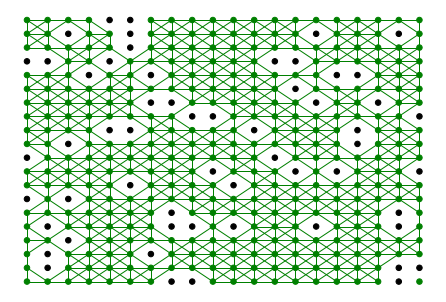

In [56]:
# ============================================== parameters to play around
nodes = 400 # number of nodes in the network
density_factor = 0.85 # network dense factor (what percent of the network will have trees); uniform rnd
# =========================================================================

scale = 100/nodes # scale to fit into visual
proximity = 1.42*scale # threshold proximity for the fire
dist_scale = 30 # for the distance of two nodes, defined from dataset
pos_dict = {} # dictionary that will hold (K,V) pairs of (node, pos)
# aspect coefficient dictionary
aspect_dict = {'N': -0.063, 'NE':0.349, 'E':0.686, 'SE':0.557, 'S':0.039, 'SW':-0.155, 'W':-0.252, 'NW':-0.171}
ele_series = df[1:nodes]['Elevation'] # get series for Elevation
ele_max = max(ele_series)
ele_min = min(ele_series) # get min and max of elevation
max_speed = 25 # user defined max wind speed possible
epsilon = 0.1 # some small value
lbls={}

g = nx.Graph() # create graph
k = 1 # node name
empty_list = [] # list of nodes that do not have trees
for i in range(1,int(np.sqrt(nodes))+1):
	for j in range(1,int(np.sqrt(nodes))+1):
		slope = df.at[k,'Slope']
		elevation = df.at[k, 'Elevation']
		aspect = df.at[k, 'Aspect']
		theta = node_threshold(slope, elevation, ele_min, ele_max, aspect, aspect_dict)
		lf = rnd.randint(3,7)
		if (rnd.uniform(0,1) > density_factor):
			g.add_node(k, threshold_switch = 1.0, color = 'black', num_of_active_neighbors = 0, fire_state = 'empty', life = lf, pos=(i*scale,j*scale))
			empty_list.append(k)
		else:
			g.add_node(k, threshold_switch = theta, color = 'green', num_of_active_neighbors = 0, fire_state = 'not_burnt', life = lf, pos=(i*scale,j*scale))
		pos_dict[k] = (i,j)
		lbls[k] = k
		k += 1

edge_list = [] # contains edge list
for i in range(1,nodes+1):
	for j in range(i,nodes+1):
		if (i == j):
			continue
		p1 = g.nodes[i]['pos']
		p2 = g.nodes[j]['pos']
		# the euclidean distance checks for whether an edge should exist, faraway nodes don't have edges
		# no edges for 'empty' (no forest)
		not_empty = g.nodes[i]['fire_state'] != 'empty' and g.nodes[j]['fire_state'] != 'empty'
		if (dist(p1,p2) < proximity*dist_scale and not_empty): 
			edge_list.append((i,j))

# add edges to the network
for edge in edge_list:
	n1 = edge[0]
	n2 = edge[1]
	ws = 0.01
	p1 = g.nodes[n1]['pos']
	p2 = g.nodes[n2]['pos']
	angle = get_angle(p1,p2)
	pp = edge_weight(max_speed, epsilon, 0, angle, dist(p1,p2))
	lf = np.floor((g.nodes[n1]['life'] + g.nodes[n2]['life'])/2)
	g.add_edge(n1, n2, w=pp, color='green', life=lf, edge_strength=0, wind_speed=ws, wind_dir=angle, eb=0)
	
edge_colors = nx.get_edge_attributes(g,'color').values()

colors=['green' for i in range(nodes)]
# nodes which don't have trees are colored black
for item in empty_list:
	colors[item-1] = 'black'

gg = copy.deepcopy(g) 
node_filename = "g_nodes.csv"
edge_filename = "g_edges.csv"
save_graph(gg, node_filename, edge_filename)

# ========================== Simulations happen below
non_empty_count = count_non_empty(g)
print("Current number of destroyed forests: ", 0, "/", non_empty_count)
print("Timestep  0:")
timesteps_list = [0]
node_colors = nx.get_node_attributes(g,'color').values()
draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
pos=nx.get_node_attributes(g,'pos')
plt.show()

### Simulation of the Fire Propagation (Original Graph)
See below for the fire propagation simulation.

Current number of destroyed forests:  222 / 343
Timestep  9 :


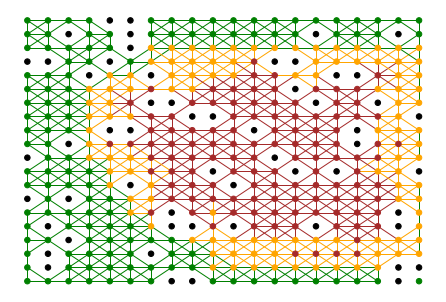

Forest fire simulation complete.
No new forests are burning.


In [67]:
# Load graph
node_file = "./g_nodes.csv"
edge_file = "./g_edges.csv"
gg = load_graph(node_file, edge_file)
g = copy.deepcopy(gg)

num = g.number_of_nodes()
ignition_node = rnd.randint(1,num+1)
while (g.nodes[ignition_node]['fire_state'] != 'not_burnt'):
	ignition_node = rnd.randint(1,num+1)
save_ignition_node = ignition_node
g.nodes[ignition_node]['fire_state'] = 'burning'
g.nodes[ignition_node]['color'] = 'orange'
colors[ignition_node-1] = 'orange'

timesteps = 20
prev_burning_forests = 0
current_burning_forests = 1
wind_xy = []
wind_widths = []
wind_heights = []
i = 1
termination = 0

igniting_forests = [0]
burnt_forests = [0]
affected_forests = [0]

while (i <= timesteps and prev_burning_forests < current_burning_forests):
	print("Current number of destroyed forests: ", (current_burning_forests + count_burnt(g)), "/", non_empty_count)
	print("Timestep ", i, ":")
	timesteps_list.append(i)
	igniting_forests.append(current_burning_forests)
	burnt_forests.append(count_burnt(g))
	affected_forests.append(current_burning_forests + count_burnt(g))
	node_colors = nx.get_node_attributes(g,'color').values()
	edge_colors = nx.get_edge_attributes(g,'color').values()
	draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
	plt.show()
	incinerate()
	lifeline_update()
	life_edge_update()
	prev_burning_forests = current_burning_forests
	current_burning_forests = count_burning(g)
	if (i%3 == 2):
		wpp = simulate_wind()
		wind_xy.append(wpp[0])
		wind_widths.append(wpp[1])
		wind_heights.append(wpp[2])
	if (i == timesteps or prev_burning_forests >= current_burning_forests):
		termination = int(prev_burning_forests >= current_burning_forests)
		break
	time.sleep(0) # recommended 2 for 100 nodes, 1 for 225 nodes, 0 for more (but that depends on your computer, you can make adjustments)
	clear_output(wait=True)
	i += 1

print("Forest fire simulation complete.")
msg = "No new forests are burning." if termination else "Reached the maximum iteration number."
print(msg)

# save new graph to local
node_file = "./g_nodes_afterfire.csv"
edge_file = "./g_edges_afterfire.csv"
save_graph(g, node_file, edge_file)

### Girvan-Newman Fire Intervention Strategy
We first employ a Girvan-Newman strategy for fire intervention. Run the code below to see the resultant graph after applying the Girvan-Newman algorithm on the original graph.

Removed edges: [(1, 2), (153, 174), (192, 213), (191, 212), (114, 135), (212, 213), (212, 233), (231, 252), (230, 251), (231, 251), (249, 270), (268, 289), (288, 289), (115, 135), (287, 308), (288, 308), (116, 137), (116, 135), (96, 117), (116, 117), (98, 117), (307, 308), (307, 328), (308, 327), (307, 327), (306, 327), (326, 347), (326, 327), (326, 346), (325, 346), (345, 346), (385, 386), (114, 133), (113, 132), (113, 133), (72, 91), (71, 90), (71, 91), (70, 71), (50, 69)]


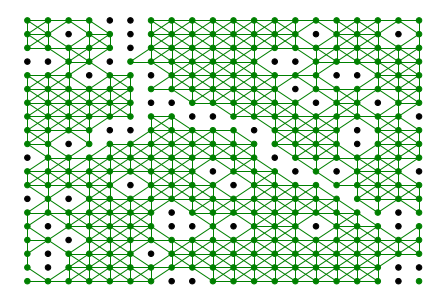

In [60]:
# Load graph
node_file = "./g_nodes.csv"
edge_file = "./g_edges.csv"
gg = load_graph(node_file, edge_file)
g = copy.deepcopy(gg)

# Apply Girvan-Newman
rem_links = remove_links_gv(g, 40)
node_colors = nx.get_node_attributes(g,'color').values()
pos_dict = nx.get_node_attributes(g, 'pos')
edge_colors = nx.get_edge_attributes(g,'color').values()
draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
print("Removed edges:", rem_links)

# save new graph to local
node_file = "./g_nodes_girvan_newman.csv"
edge_file = "./g_edges_girvan_newman.csv"
save_graph(g, node_file, edge_file)

### Simulate Fire Propagation in the Girvan-Newman Graph
Use the graph of the Girvan-Newman result to run a fire propagation simulation.

Current number of destroyed forests:  125 / 343
Timestep  10 :


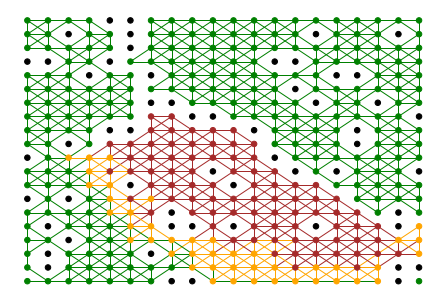

Forest fire simulation complete.
No new forests are burning.


In [61]:
# load graph
node_file = "./g_nodes_girvan_newman.csv"
edge_file = "./g_edges_girvan_newman.csv"
gg = load_graph(node_file, edge_file)
g = copy.deepcopy(gg)

# ========================== Simulations happen below
non_empty_count = count_non_empty(g)
print("Current number of destroyed forests: ", 0, "/", non_empty_count)
print("Timestep  0:")
timesteps_list = [0]
igniting_forests = [0]
burnt_forests = [0]
affected_forests = [0]
node_colors = nx.get_node_attributes(g,'color').values()
pos_dict = nx.get_node_attributes(g, 'pos')
edge_colors = nx.get_edge_attributes(g,'color').values()
draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
pos=nx.get_node_attributes(g,'pos')
plt.show()
time.sleep(1)
clear_output(wait=True)

num = g.number_of_nodes()
ignition_node = save_ignition_node # same ignition node from original graph
g.nodes[ignition_node]['fire_state'] = 'burning'
g.nodes[ignition_node]['color'] = 'orange'
colors[ignition_node-1] = 'orange'

timesteps = 20
prev_burning_forests = 0
current_burning_forests = 1
wind_xy = []
wind_widths = []
wind_heights = []
i = 1
termination = 0

affected_forests_gv = [0]

while (i <= timesteps and prev_burning_forests < current_burning_forests):
	print("Current number of destroyed forests: ", (current_burning_forests + count_burnt(g)), "/", non_empty_count)
	print("Timestep ", i, ":")
	timesteps_list.append(i)
	igniting_forests.append(current_burning_forests)
	burnt_forests.append(count_burnt(g))
	affected_forests_gv.append(current_burning_forests + count_burnt(g))
	node_colors = nx.get_node_attributes(g,'color').values()
	pos_dict = nx.get_node_attributes(g, 'pos')
	edge_colors = nx.get_edge_attributes(g,'color').values()
	draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
	plt.show()
	incinerate()
	lifeline_update()
	life_edge_update()
	prev_burning_forests = current_burning_forests
	current_burning_forests = count_burning(g)
	if (i%3 == 2):
		wpp = simulate_wind()
		wind_xy.append(wpp[0])
		wind_widths.append(wpp[1])
		wind_heights.append(wpp[2])
	if (i == timesteps or prev_burning_forests >= current_burning_forests):
		termination = int(prev_burning_forests >= current_burning_forests)
		break
	time.sleep(0)
	clear_output(wait=True)
	i += 1

print("Forest fire simulation complete.")
msg = "No new forests are burning." if termination else "Reached the maximum iteration number."
print(msg)

# save new graph to local
node_file = "./g_nodes_girvan_newman_afterfire.csv"
edge_file = "./g_edges_girvan_newman_afterfire.csv"
save_graph(g, node_file, edge_file)

### FIGHTER Algorithm Fire Intervention
From the original graph, we create a resultant graph from the removed edges based on our **FIGHTER** algroithm.

Removed edges: [(1, 2), (153, 174), (192, 213), (191, 212), (114, 135), (212, 213), (212, 233), (231, 252), (230, 251), (231, 251), (249, 270), (268, 289), (288, 289), (115, 135), (287, 308), (288, 308), (116, 137), (116, 135), (96, 117), (116, 117), (98, 117), (307, 308), (307, 328), (308, 327), (307, 327), (306, 327), (326, 347), (326, 327), (326, 346), (325, 346), (345, 346), (385, 386), (114, 133), (113, 132), (113, 133), (72, 91), (71, 90), (71, 91), (70, 71), (50, 69)]


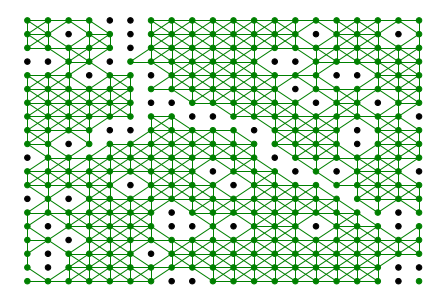

In [62]:
# Load graph
node_file = "./g_nodes.csv"
edge_file = "./g_edges.csv"
g_test = load_graph(node_file, edge_file)
g = copy.deepcopy(g_test)

# remove edges from the original graph 
rem_links = remove_links_fighter(g, 40, 5*dist_scale)
node_colors = nx.get_node_attributes(g,'color').values()
pos_dict = nx.get_node_attributes(g, 'pos')
edge_colors = nx.get_edge_attributes(g,'color').values()
draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
print("Removed edges:", rem_links)

# save new graph to local
node_file = "./g_nodes_fighter.csv"
edge_file = "./g_edges_fighter.csv"
save_graph(g, node_file, edge_file)

### Simulate Fire Propagation in the FIGHTER Graph
Use the graph of the **FIGHTER** result to run a fire propagation simulation.

Current number of destroyed forests:  125 / 343
Timestep  10 :


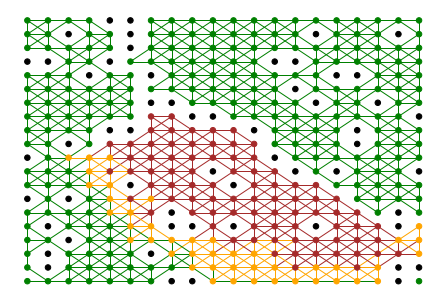

Forest fire simulation complete.
No new forests are burning.


In [63]:
# load graph
node_file = "./g_nodes_fighter.csv"
edge_file = "./g_edges_fighter.csv"
gg = load_graph(node_file, edge_file)
g = copy.deepcopy(gg)

non_empty_count = count_non_empty(g)
print("Current number of destroyed forests: ", 0, "/", non_empty_count)
print("Timestep  0:")
timesteps_list = [0]
igniting_forests = [0]
burnt_forests = [0]
affected_forests = [0]
node_colors = nx.get_node_attributes(g,'color').values()
pos_dict = nx.get_node_attributes(g, 'pos')
edge_colors = nx.get_edge_attributes(g,'color').values()
draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
pos=nx.get_node_attributes(g,'pos')
plt.show()
time.sleep(1)
clear_output(wait=True)

num = g.number_of_nodes()
ignition_node = save_ignition_node
g.nodes[ignition_node]['fire_state'] = 'burning'
g.nodes[ignition_node]['color'] = 'orange'
colors[ignition_node-1] = 'orange'

timesteps = 20
prev_burning_forests = 0
current_burning_forests = 1
wind_xy = []
wind_widths = []
wind_heights = []
i = 1
termination = 0

affected_forests_ff = [0]

while (i <= timesteps and prev_burning_forests < current_burning_forests):
	print("Current number of destroyed forests: ", (current_burning_forests + count_burnt(g)), "/", non_empty_count)
	print("Timestep ", i, ":")
	timesteps_list.append(i)
	igniting_forests.append(current_burning_forests)
	burnt_forests.append(count_burnt(g))
	affected_forests_ff.append(current_burning_forests + count_burnt(g))
	node_colors = nx.get_node_attributes(g,'color').values()
	pos_dict = nx.get_node_attributes(g, 'pos')
	edge_colors = nx.get_edge_attributes(g,'color').values()
	draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
	plt.show()
	incinerate()
	lifeline_update()
	life_edge_update()
	prev_burning_forests = current_burning_forests
	current_burning_forests = count_burning(g)
	if (i%3 == 2):
		wpp = simulate_wind()
		wind_xy.append(wpp[0])
		wind_widths.append(wpp[1])
		wind_heights.append(wpp[2])
	if (i == timesteps or prev_burning_forests >= current_burning_forests):
		termination = int(prev_burning_forests >= current_burning_forests)
		break
	time.sleep(0)
	clear_output(wait=True)
	i += 1

print("Forest fire simulation complete.")
msg = "No new forests are burning." if termination else "Reached the maximum iteration number."
print(msg)

# save new graph to local
node_file = "./g_nodes_fighter_afterfire.csv"
edge_file = "./g_edges_fighter_afterfire.csv"
save_graph(g, node_file, edge_file)